<a href="https://colab.research.google.com/github/stephenbeckr/time-series-class/blob/main/Demos/TimeSeries_ModelSelectionExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series class
Demo by Will Kleiber 2018, modified by Stephen Becker 2022

Demo in class Fri March 11 2022

Data is montly ozone concentratoin in downtown LA, 1955-1972

In [2]:
install.packages("itsmr")
library(itsmr)  # our textbook's package is ITSM, and ITSMR is a R version
load(url("https://github.com/stephenbeckr/time-series-class/raw/main/Data/HW3data.RData"))
rm(list=ls()[1:5])
ls()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "dat.F"

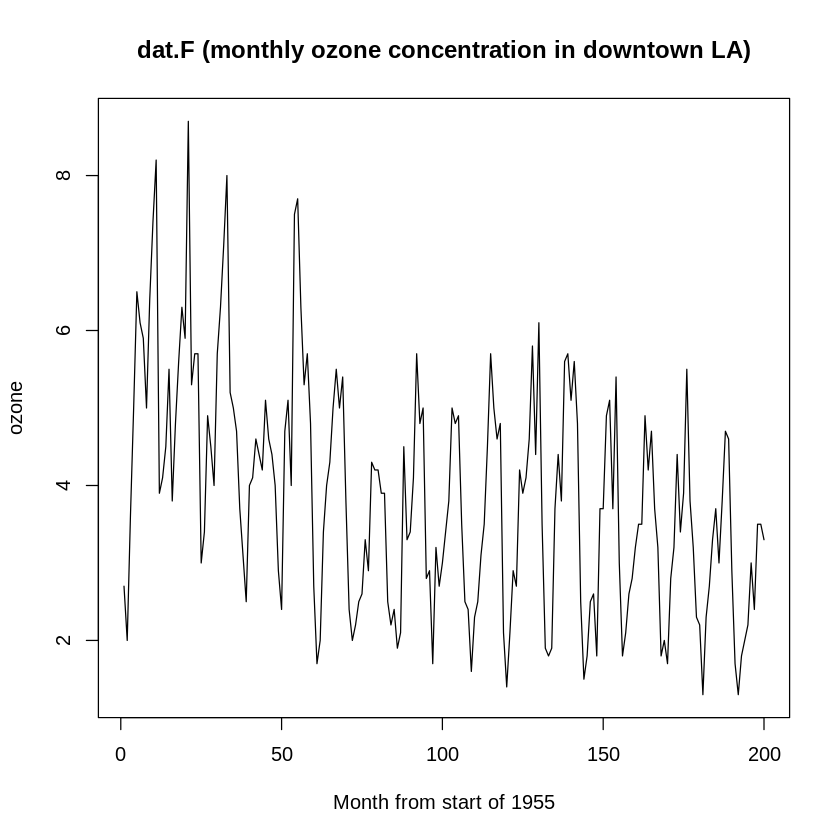

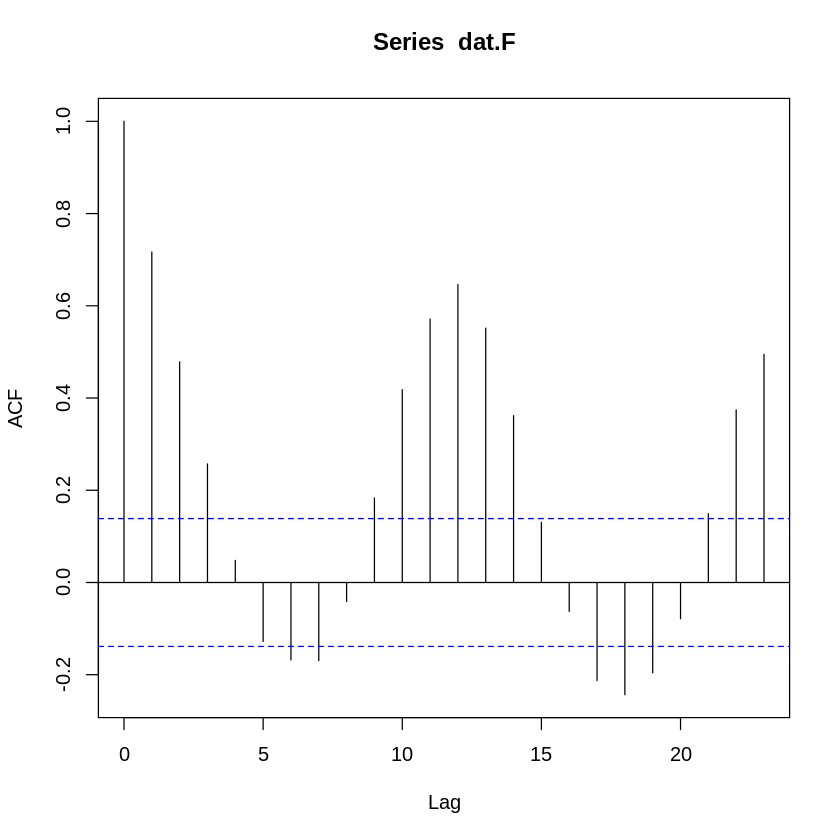

In [3]:
plot(dat.F,type="l",main="dat.F (monthly ozone concentration in downtown LA)",xlab="Month from start of 1955",ylab="ozone")
acf(dat.F) # note high periodicity at lag 12

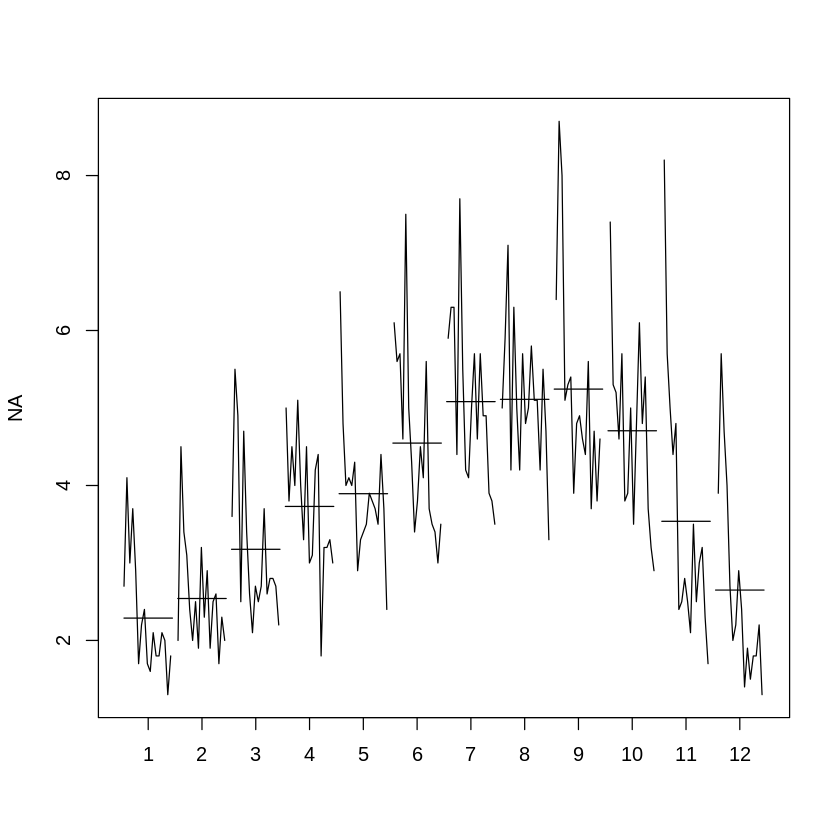

In [5]:
monthplot( dat.F )

## One possible model for the trend/seasonality

In [6]:
X <- matrix(nr=200,nc=7)
time <- 1:200
X[,1] <- 1
X[,2] <- time
X[,3] <- time^2
X[,4] <- cos(2*pi*time/12)
X[,5] <- sin(2*pi*time/12)
X[,6] <- cos(2*2*pi*time/12)
X[,7] <- sin(2*2*pi*time/12)

mod <- lm(dat.F~X-1) # the -1 takes out an automatic intercept, since X[,1] holds that
mod
summary(mod)
beta.hat <- mod$coef

# get residuals
resid <- mod$resid


Call:
lm(formula = dat.F ~ X - 1)

Coefficients:
        X1          X2          X3          X4          X5          X6  
 5.484e+00  -2.437e-02   6.265e-05  -9.105e-01  -1.085e+00  -2.990e-01  
        X7  
-1.287e-01  



Call:
lm(formula = dat.F ~ X - 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0781 -0.5501 -0.0881  0.4389  3.2610 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)    
X1  5.484e+00  1.789e-01  30.655  < 2e-16 ***
X2 -2.437e-02  4.110e-03  -5.930 1.37e-08 ***
X3  6.265e-05  1.980e-05   3.163 0.001813 ** 
X4 -9.105e-01  8.345e-02 -10.910  < 2e-16 ***
X5 -1.085e+00  8.345e-02 -13.002  < 2e-16 ***
X6 -2.990e-01  8.358e-02  -3.577 0.000439 ***
X7 -1.287e-01  8.320e-02  -1.547 0.123474    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8335 on 193 degrees of freedom
Multiple R-squared:  0.961,	Adjusted R-squared:  0.9596 
F-statistic: 679.3 on 7 and 193 DF,  p-value: < 2.2e-16


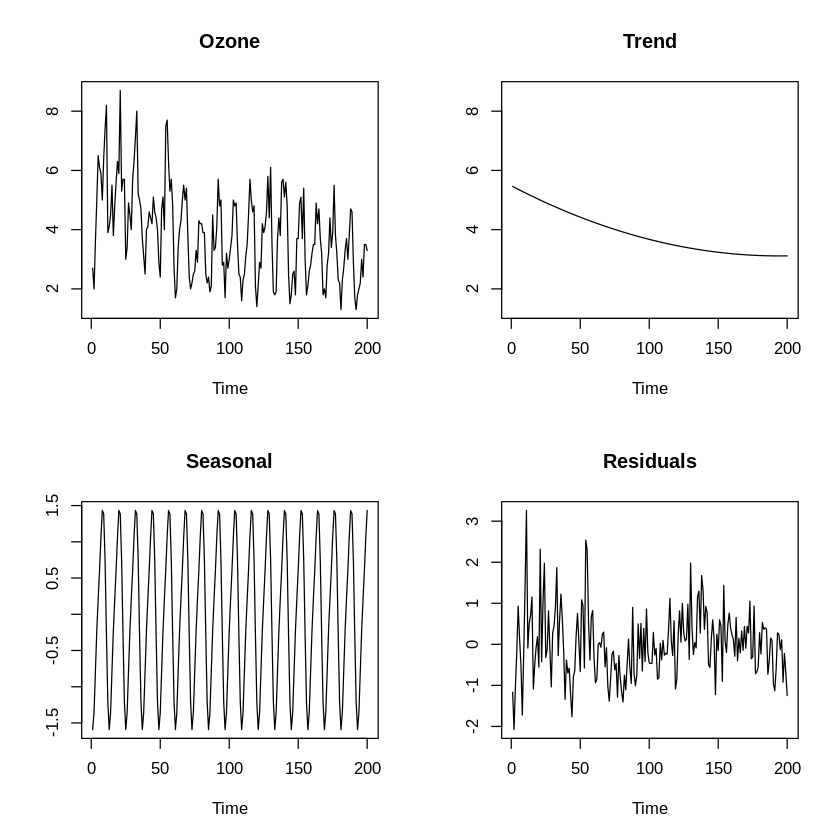

In [7]:
par(mfrow=c(2,2))
plot(dat.F,type="l",xlab="Time",ylab="",main="Ozone")
plot(X[,1:3] %*% cbind(beta.hat[1:3]),
     type="l",xlab="Time",ylab="",main="Trend",
  ylim=range(dat.F))
plot(X[,4:7] %*% cbind(beta.hat[4:7]),
     type="l",xlab="Time",ylab="",main="Seasonal")
plot(resid,type="l",xlab="Time",ylab="",main="Residuals")

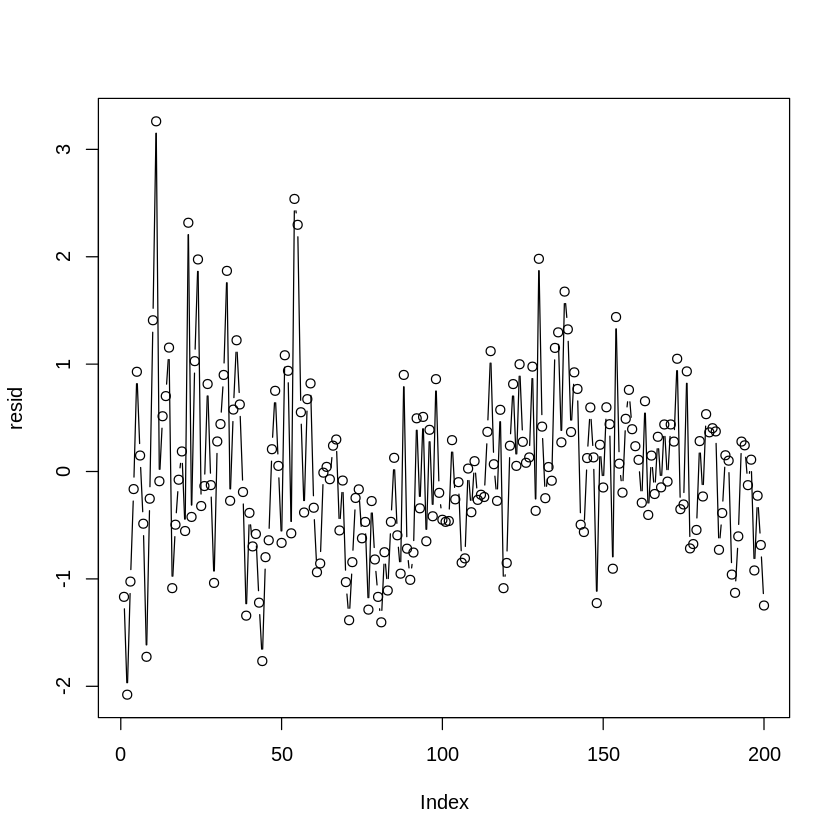

In [8]:
plot(resid,type="b")

In [9]:
?test

Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)      39.6    0.0056 *
McLeod-Li Q                Q ~ chisq(20)     35.93    0.0157 *
Turning points T    (T-132)/5.9 ~ N(0,1)       124    0.1777
Diff signs S       (S-99.5)/4.1 ~ N(0,1)       101     0.714
Rank P           (P-9950)/473.2 ~ N(0,1)     10328    0.4244


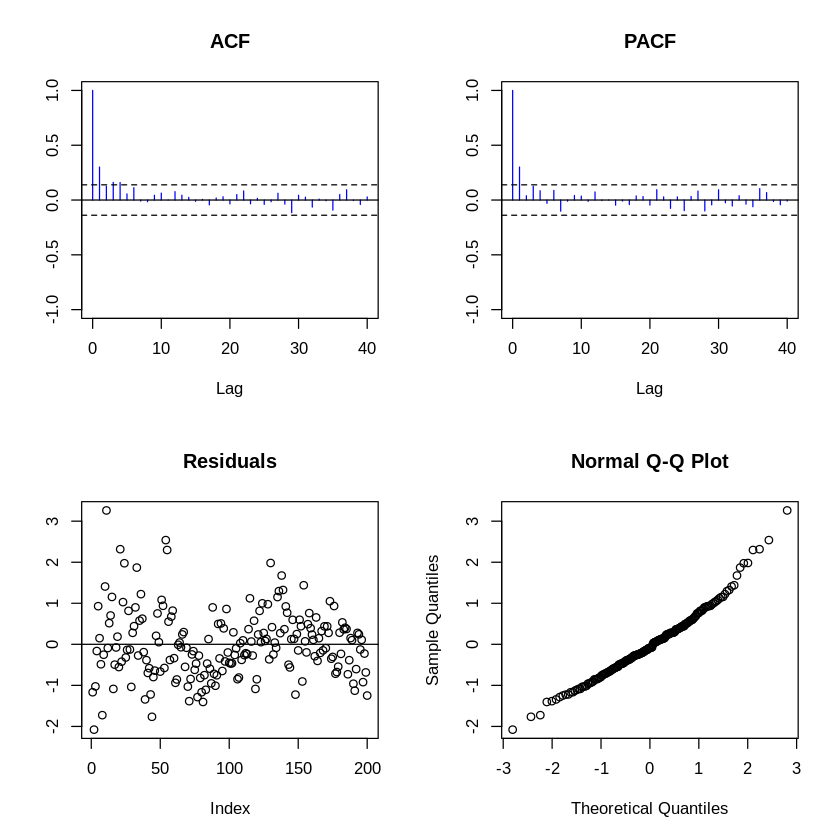

In [18]:
itsmr::test(resid)

and recall "the p-value is the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct."  So the two tests marked with the * strongly suggest that this is not consistent with iid noise (and probably not with WN neither)

Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)     21.44    0.3715
McLeod-Li Q                Q ~ chisq(20)     12.01    0.9156
Turning points T    (T-132)/5.9 ~ N(0,1)       129    0.6133
Diff signs S       (S-99.5)/4.1 ~ N(0,1)        94     0.179
Rank P           (P-9950)/473.2 ~ N(0,1)      9855    0.8409


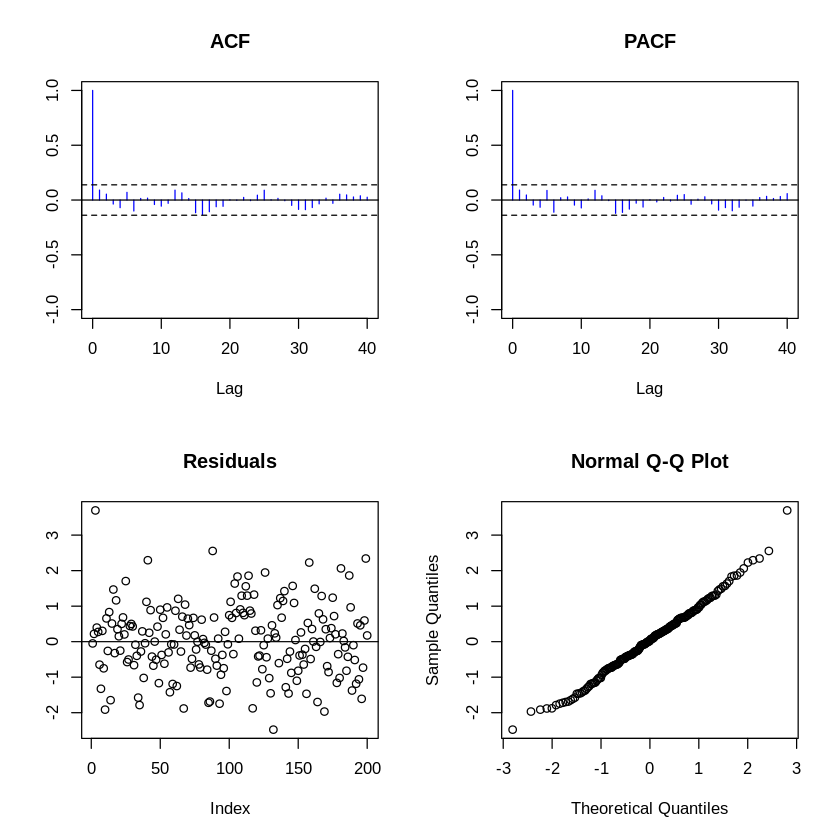

In [12]:
# What should this look like? Let's try on things that are and are not WN
test( rnorm(200) )

Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)   3045.97         0 *
McLeod-Li Q                Q ~ chisq(20)    3002.3         0 *
Turning points T    (T-132)/5.9 ~ N(0,1)         0         0 *
Diff signs S       (S-99.5)/4.1 ~ N(0,1)       199         0 *
Rank P           (P-9950)/473.2 ~ N(0,1)     19900         0 *


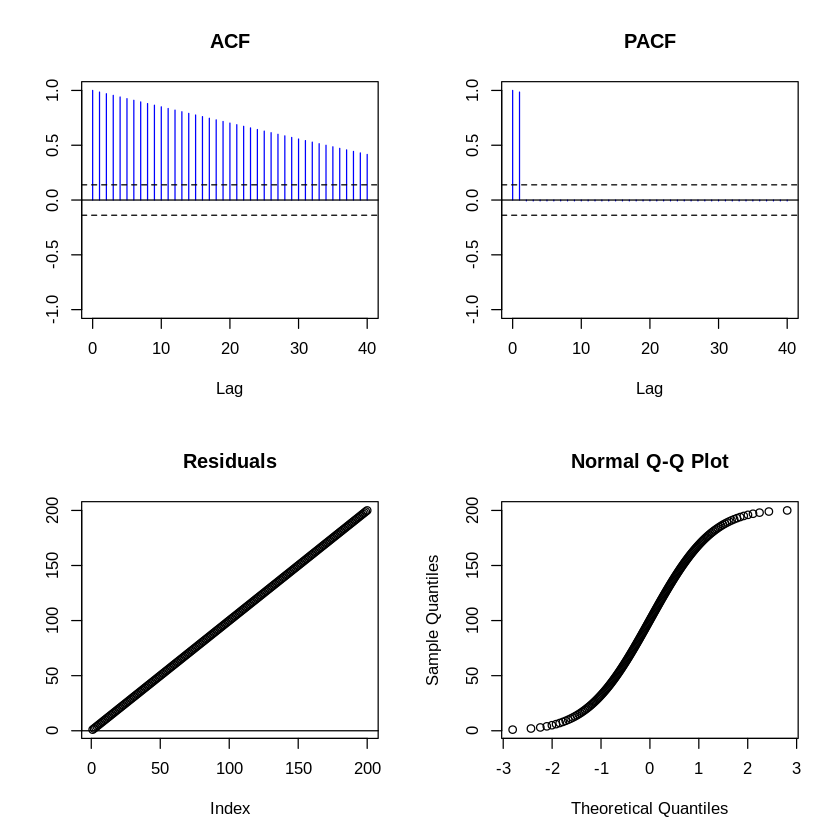

In [13]:
# What should this look like? Let's try on things that are and are not WN
test( 1:200 )

## Let's model the residual further
Assume that we're happy with our seasonal decomposition, but the residuals still have correlation so they are not WN. Let's try an ARMA model

In [16]:
# in the usual R stats package, use arima() (or ar() if no MA)
#   e.g., fit <- arima(x=resid,order=c(0,0,0) )
#   By default it uses the AICC criteria

# Here, we'll show the itsmr::arma() function from ITSM

fit00 <- arma(x=resid, p=0,q=0 )
names(fit00)
fit10 <- arma(x=resid, p=1,q=0 )
fit11 <- arma(x=resid, p=1,q=1 )

fit00$aicc
fit10$aicc # lower = better AIC
fit11$aicc

[1] "phi"      "theta"    "sigma2"   "aicc"     "se.phi"   "se.theta"

[1] 489.6418

[1] 472.3591

[1] 472.3235

In [20]:
#?itsmr::autofit
fit <- autofit(resid)
fit

Warning message in sqrt(v[1:p]):
“NaNs produced”
Warning message in sqrt(v[(p + 1):(p + q)]):
“NaNs produced”


$phi
[1] 0.7300049

$theta
[1] -0.4926959

$sigma2
[1] 0.6019322

$aicc
[1] 472.3235

$se.phi
[1] 0.1611865

$se.theta
[1] 0.2069976

Causal
Invertible


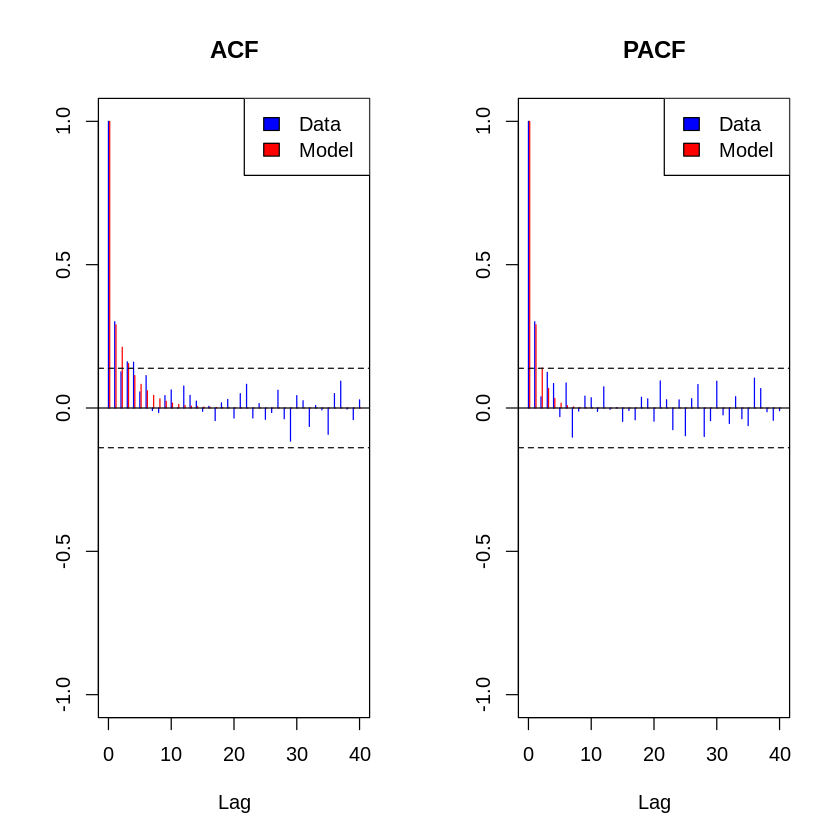

In [26]:
## => model is ARMA(1,1) with phi = 0.73, theta = -0.49
itsmr::check(fit) # nice. Check for causality and invertibility
## Check ACF and PACF fits:
# itsmr::plota(resid) # Plot data and/or model ACF and PACF
# plota(fit)
plota(resid,fit)

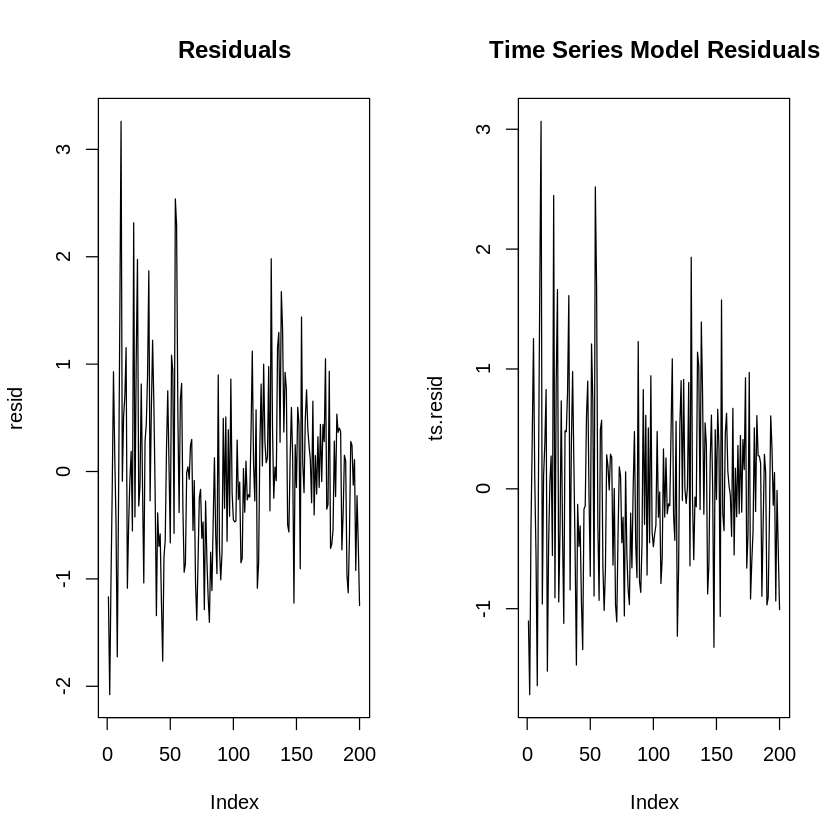

Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)     11.95    0.9177
McLeod-Li Q                Q ~ chisq(20)     39.01    0.0066 *
Turning points T    (T-132)/5.9 ~ N(0,1)       124    0.1777
Diff signs S       (S-99.5)/4.1 ~ N(0,1)        98     0.714
Rank P           (P-9950)/473.2 ~ N(0,1)     10255    0.5192


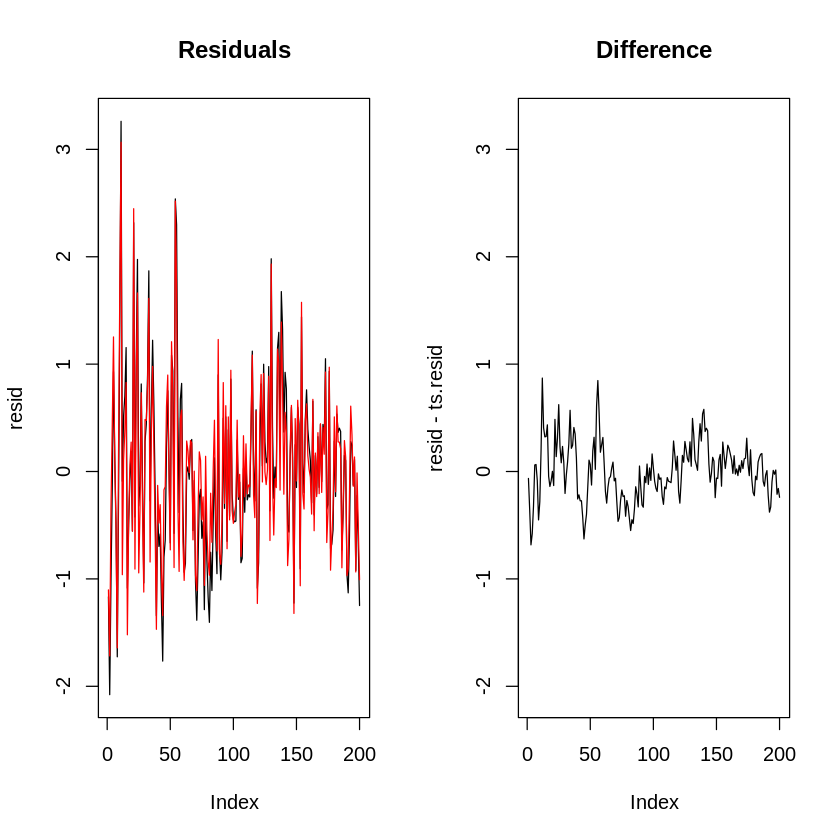

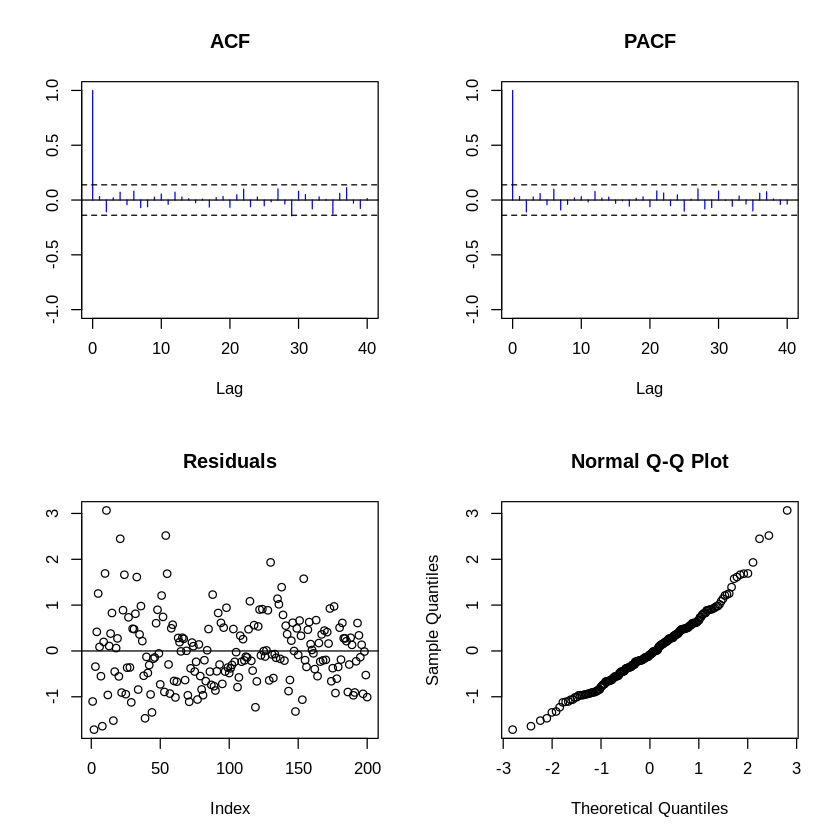

In [29]:
## Compute residuals from ARMA(1,1) model:
ts.resid <- itsmr::Resid(resid,M=NULL,a=fit)
par(mfrow=c(1,2))
plot(resid,type="l",main="Residuals")
plot(ts.resid,type="l",main="Time Series Model Residuals")

plot(resid,type="l",main="Residuals")
lines(ts.resid,col="red")

plot(resid-ts.resid,type="l",main="Difference",ylim=range(resid))

test(ts.resid) # perhaps more like WN?
# except for the heteroskedasticity

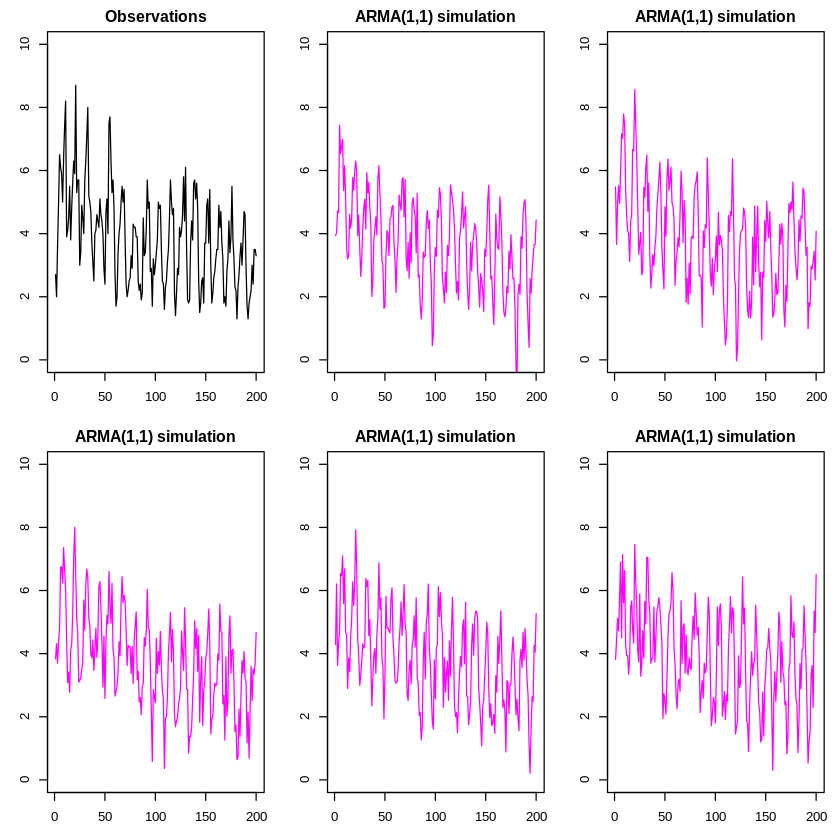

In [31]:
## Simulate a whole trajectory of "ozone" and compare to data:
set.seed(3)
par(mfrow=c(2,3))
par( mar=c(3,3,2,1))
plot(dat.F,type="l",main="Observations",xlab="", ylab="",ylim=c(0,10))
for(i in 2:6){
  # adding back in seasonality and trend (mod$fit)
  plot(mod$fit + itsmr::sim(a=fit,n=200), type="l",
    col="magenta", main="ARMA(1,1) simulation", ylim=c(0,10), xlab="", ylab="")
}

## Our residuals seemed a bit heteroscedastic...
There are many formal tests to look for this. We can see it easy enough by eye.

Furthermore, this will give us a method to correct for it by hand. 

(Another simple way would be a Box-Cox transformation, which sometimes works, but isn't **guaranteed** to work for all types of heteroscedasticity)

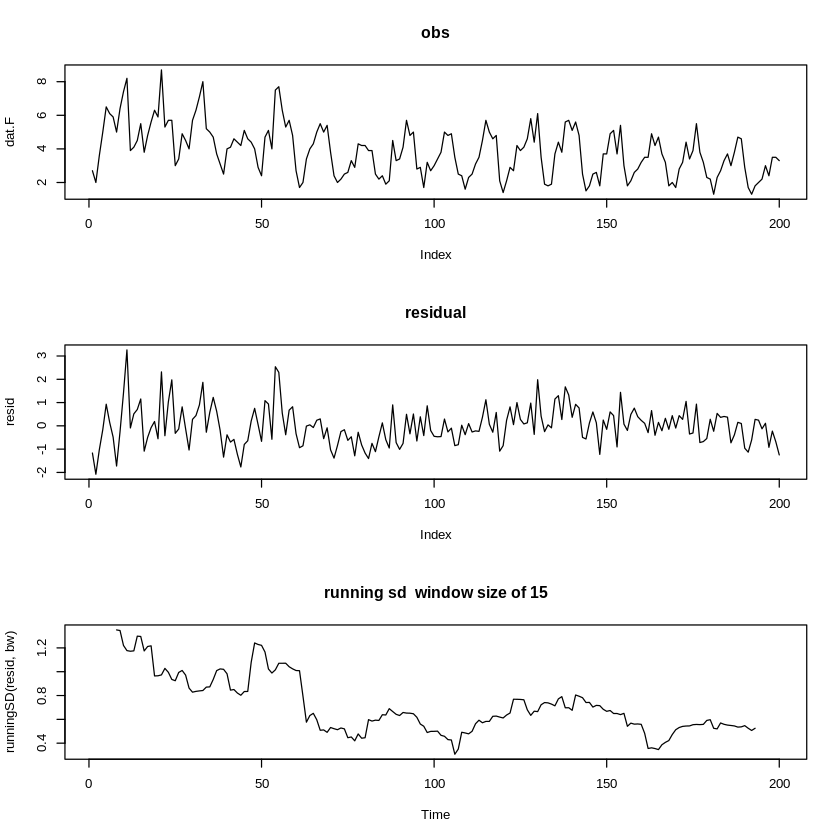

In [33]:
##
## An approach for problems with a changing variance (heteroskedasticity)
##

runningSD <- function(x, n=5){
  mn <- filter(x,rep(1/n,n), sides=2)
  x2 <- filter(x^2,rep(1/n,n), sides=2)
  SD <- sqrt( (x2- mn^2) * (n/(n-1)) )
  return(SD)
}

bw <- 15

par(mfrow=c(3,1))
plot(dat.F,type="l")
title("obs")
plot(resid,type="l")
title("residual")
plot(runningSD(resid,bw))
title(paste("running sd  window size of",bw))

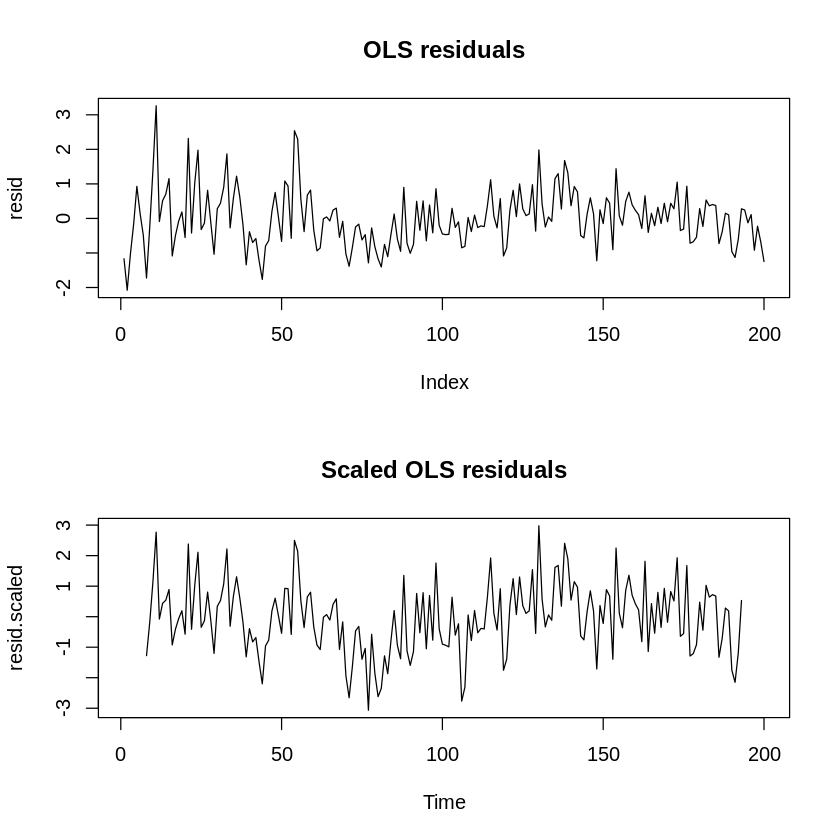

In [34]:
## Scale out the estimated local SD
local.sd <- runningSD(resid,bw)
resid.scaled <- resid / local.sd

par(mfrow=c(2,1))
plot(resid,type="l",main="OLS residuals")
plot(resid.scaled,type="l",main="Scaled OLS residuals")

In [37]:
## Fit time series model to scaled residuals
# fit <- autofit(resid.scaled)  # gives an error... so try this:
fit <- autofit(na.omit(resid.scaled))
fit
check(fit)

$phi
[1] 0.869204

$theta
[1] -0.6772282

$sigma2
[1] 1.130164

$aicc
[1] 556.9821

$se.phi
[1] 0.07988219

$se.theta
[1] 0.1210094

Causal
Invertible


Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)      9.17    0.9808
McLeod-Li Q                Q ~ chisq(20)     27.71    0.1164
Turning points T  (T-122.7)/5.7 ~ N(0,1)       114    0.1299
Diff signs S       (S-92.5)/3.9 ~ N(0,1)        96    0.3753
Rank P         (P-8602.5)/424.5 ~ N(0,1)      8741    0.7442


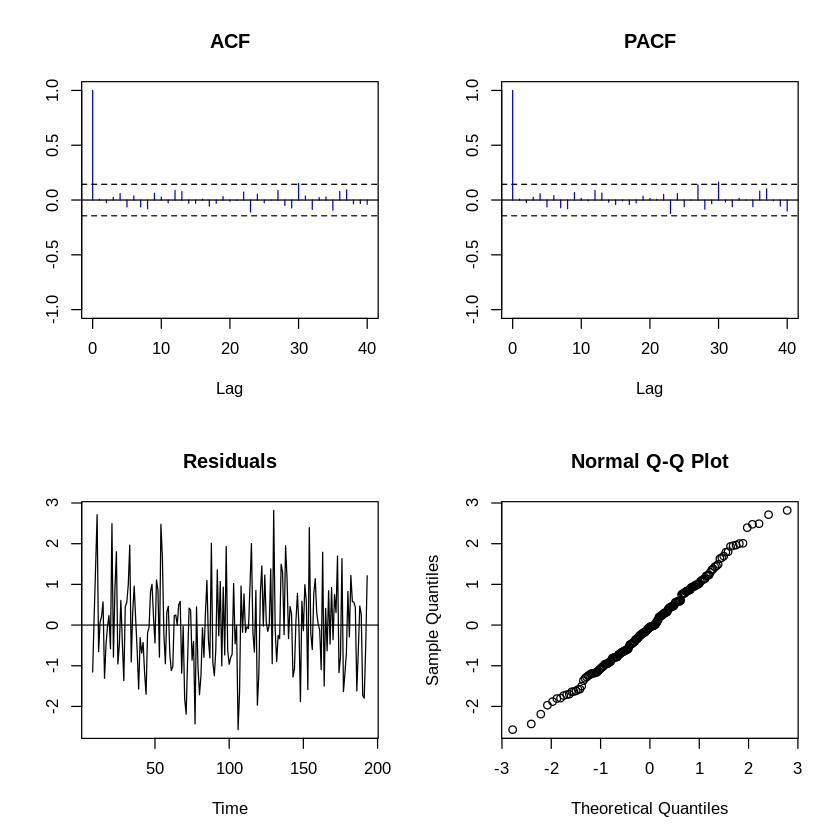

In [38]:
## Check time series residuals
ts.resid <- Resid(na.omit(resid.scaled),M=NULL,a=fit)
test(ts.resid)

Looks better!

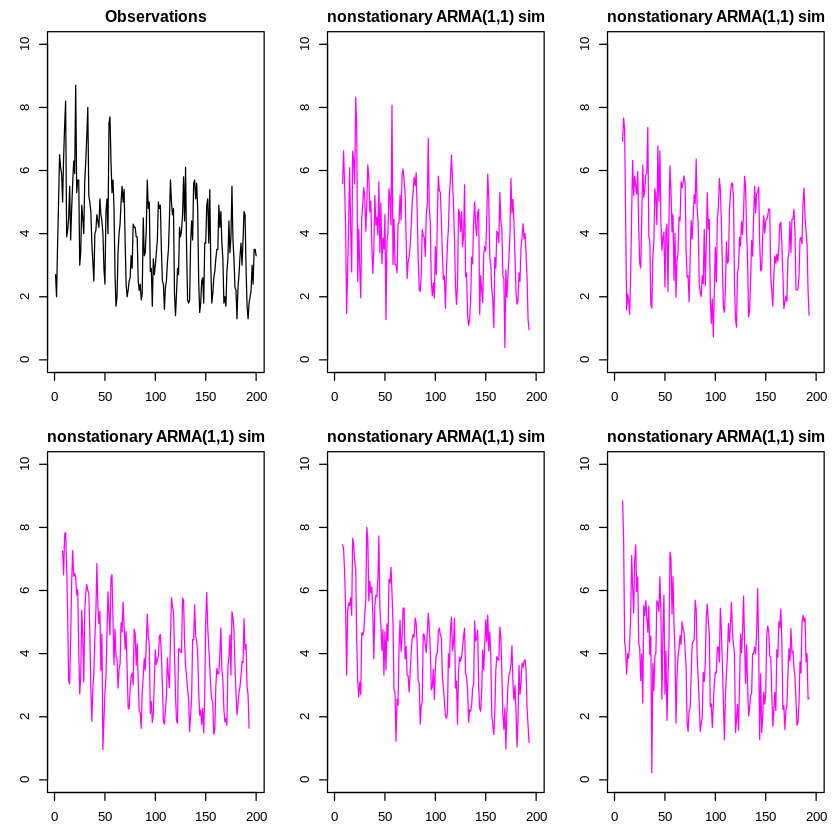

In [39]:
## Simulate a whole trajectory of "ozone" and compare to data:
# (sanity check)
set.seed(11)
par(mfrow=c(2,3),mar=c(3,3,2,1))
plot(dat.F,type="l",main="Observations",xlab="", ylab="",ylim=c(0,10))
for(i in 2:6){
  plot(mod$fit + sim(a=fit,n=200) * local.sd,type="l",
    col="magenta", main="nonstationary ARMA(1,1) sim",ylim=c(0,10), xlab="", ylab="")
}

$phi
[1] -0.1250198 -0.1706501  0.8367771

$theta
[1]  0.3568489  0.3532416 -0.6453393

$sigma2
[1] 1.02612

$aicc
[1] 591.3027

$se.phi
[1] 0.09741292 0.09687003 0.09509347

$se.theta
[1] 0.1405767 0.1462101 0.1413930

Causal
Invertible
Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)      6.57    0.9979
McLeod-Li Q                Q ~ chisq(20)     33.17    0.0323 *
Turning points T    (T-132)/5.9 ~ N(0,1)       120    0.0432 *
Diff signs S       (S-99.5)/4.1 ~ N(0,1)       101     0.714
Rank P           (P-9950)/473.2 ~ N(0,1)     10023    0.8774


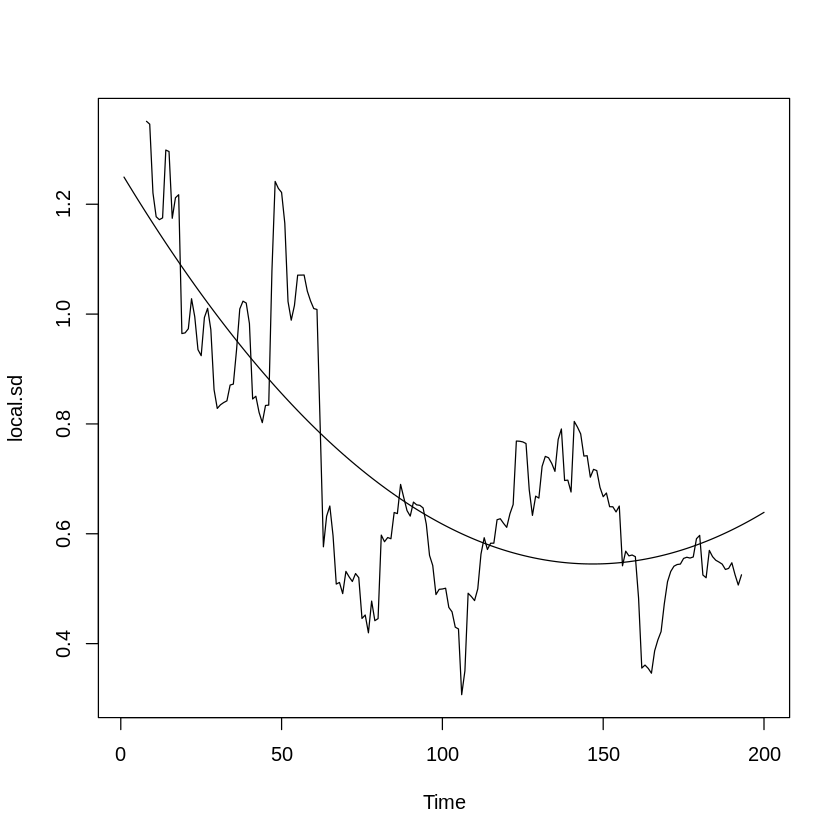

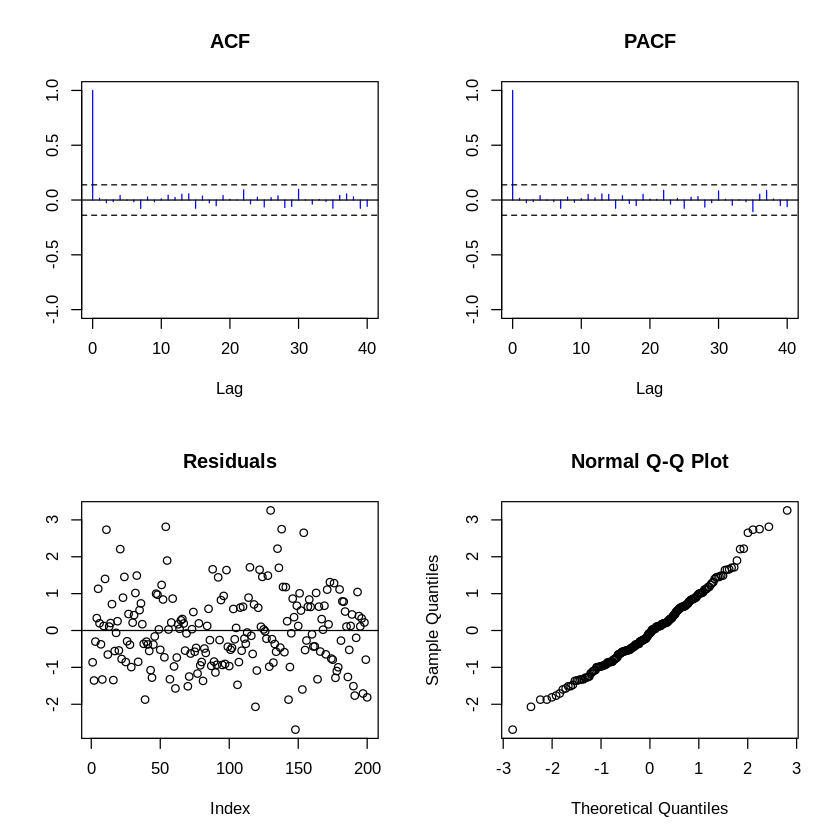

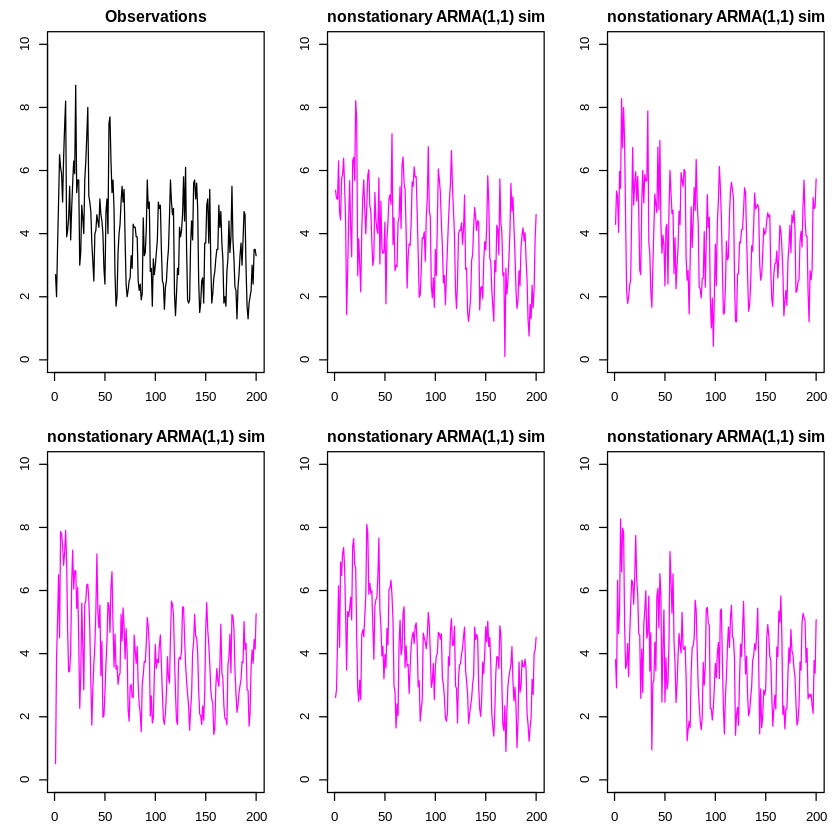

In [40]:
## Or fit a parametric function to the local SD
plot(local.sd,type="l")
times <- data.frame(times=1:200)
sd.model <- lm(local.sd~poly(x=times,degree=2),data=times)
sd.fitted <- predict(object=sd.model,newdata=times)
lines(sd.fitted)

resid.scaled <- resid / sd.fitted
fit <- autofit(resid.scaled)
fit
check(fit)

ts.resid <- Resid(na.omit(resid.scaled),M=NULL,a=fit)
test(ts.resid)

set.seed(11)
par(mfrow=c(2,3),mar=c(3,3,2,1))
plot(dat.F,type="l",main="Observations",xlab="", ylab="",ylim=c(0,10))
for(i in 2:6){
  plot(mod$fit + sim(a=fit,n=200) * sd.fitted,type="l",
    col="magenta", main="nonstationary ARMA(1,1) sim",ylim=c(0,10), xlab="", ylab="")
}